In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.seasonal import STL
import numpy as np
from datetime import datetime

In [2]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [3]:
data = pd.read_csv('daily_data.csv')
data.index = pd.to_datetime(data.date)

start_dt = datetime.strptime('06/04/2018', "%d/%m/%Y")
data = data[(data.index >= start_dt)]

data['prexmas'] = data.index.week.isin([50,51]).astype(int)
data['xmas'] = data.index.week.isin([52,1]).astype(int)
data['dow'] = data.index.dayofweek
data['we'] = data.dow.isin([5,6]).astype(int)
data = data['2018-02-12':]
data = data.asfreq('d')
data.head()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2018-04-06,2018-04-06,29.99,1.0,6.930769,10.166667,0.0,0.0,26.0,51.0,0.509804,41.0,33.0,0,0,4,0
2018-04-07,2018-04-07,29.99,2.0,6.930769,12.111111,0.0,2.0,26.0,53.0,0.490566,28.0,27.0,0,0,5,1
2018-04-08,2018-04-08,29.99,2.0,6.930769,10.000000,0.0,6.0,26.0,59.0,0.440678,30.0,24.0,0,0,6,1
2018-04-09,2018-04-09,29.99,0.0,6.930769,8.777778,0.0,0.0,26.0,59.0,0.440678,30.0,26.0,0,0,0,0
2018-04-10,2018-04-10,27.99,1.0,6.930769,10.555556,0.0,0.0,26.0,59.0,0.440678,29.0,26.0,0,0,1,0


In [4]:
"""
Lets consider a specific model for the quantity of sales:
There are three interacting components for Quantity of Sales (Q):

i) Customer Demand (D), ie daily searches for the product type.

ii) Amazon Traffic (T), rate of searches that are directed by Amazon to the product page (the mechanism behind this 
traffic rate is the ranking of the product within the search algorithm).

iii) Conversions (C), rate of traffic to product site resulting in sales.

where Q = D * Trate * C

let D = aX(d)(t), where X(d) = {c(d), temperature, xmas, we}
let T = bX(t)(t, t-1, t-2, ...), where X(t) = {c(t), advertising, score, AR(), MA()}
let C = cX(c)(t), where X(c) = {c(c), price, quality(~score)}

we assume C constant, ie conversion is constant
we assume c(t) = 0, ie no advertising or score of previous sales will result in a zero rate of conversion

q = A * ([B, w, x, we]*[C, a, s, AR, MA])
q = a * [BC, Ba, Bs, BAR, BMA, wC, wa, ws, wAR, wMA, xC, xa, xs, xAR xMA, wC, wea, wes, weAR weMA]

we test for the significance of the AR and MA processes in this model and interpret them
"""

'\nLets consider a specific model for the quantity of sales:\nThere are three interacting components for Quantity of Sales (Q):\n\ni) Customer Demand (D), ie daily searches for the product type.\n\nii) Amazon Traffic (T), rate of searches that are directed by Amazon to the product page (the mechanism behind this \ntraffic rate is the ranking of the product within the search algorithm).\n\niii) Conversions (C), rate of traffic to product site resulting in sales.\n\nwhere Q = D * Trate * C\n\nlet D = aX(d)(t), where X(d) = {c(d), temperature, xmas, we}\nlet T = bX(t)(t, t-1, t-2, ...), where X(t) = {c(t), advertising, score, AR(), MA()}\nlet C = cX(c)(t), where X(c) = {c(c), price, quality(~score)}\n\nwe assume C constant, ie conversion is constant\nwe assume c(t) = 0, ie no advertising or score of previous sales will result in a zero rate of conversion\n\nq = A * ([B, w, x, we]*[C, a, s, AR, MA])\nq = a * [BC, Ba, Bs, BAR, BMA, wC, wa, ws, wAR, wMA, xC, xa, xs, xAR xMA, wC, wea, wes, we

In [5]:
data.head()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2018-04-06,2018-04-06,29.99,1.0,6.930769,10.166667,0.0,0.0,26.0,51.0,0.509804,41.0,33.0,0,0,4,0
2018-04-07,2018-04-07,29.99,2.0,6.930769,12.111111,0.0,2.0,26.0,53.0,0.490566,28.0,27.0,0,0,5,1
2018-04-08,2018-04-08,29.99,2.0,6.930769,10.000000,0.0,6.0,26.0,59.0,0.440678,30.0,24.0,0,0,6,1
2018-04-09,2018-04-09,29.99,0.0,6.930769,8.777778,0.0,0.0,26.0,59.0,0.440678,30.0,26.0,0,0,0,0
2018-04-10,2018-04-10,27.99,1.0,6.930769,10.555556,0.0,0.0,26.0,59.0,0.440678,29.0,26.0,0,0,1,0


In [6]:
data.tail()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2020-02-03,2020-02-03,29.99,3.0,5.248167,9.055556,0.0,4.0,263.0,458.0,0.574236,146.0,111.0,0,0,0,0
2020-02-04,2020-02-04,29.99,12.0,5.248167,6.944444,0.0,4.0,263.0,462.0,0.569264,153.0,115.0,0,0,1,0
2020-02-05,2020-02-05,29.99,9.0,5.248167,4.833333,0.0,2.0,263.0,464.0,0.566810,138.0,103.0,0,0,2,0
2020-02-06,2020-02-06,29.99,4.0,5.248167,3.611111,0.0,0.0,263.0,464.0,0.566810,149.0,117.0,0,0,3,0
2020-02-07,2020-02-07,29.99,10.0,5.248167,5.611111,0.0,0.0,263.0,464.0,0.566810,126.0,111.0,0,0,4,0


In [7]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def ols_combinations_helper(data, endog, combination):
    y = data[endog]
    x = data[combination]
#     x = sm.add_constant(x)
    model = ARIMA(
        y,
        order=(0,0,0),
        exog=data[combination]
    )
#     model = sm.OLS(y, x)
    return model.fit()

def build_interacting_arma(data, endog, exog, interacting_exog_endog, ar_lags=0, ma_lags=0, restrict=None):
    
    x_col = exog
    new_df = data.loc[:, set([endog]  + exog + interacting_exog_endog)]
    
    print('adding AR lags')
    for i in range(1, ar_lags+1):
        name = f"AR{i}"
        print(name)
        x_col.append(name)
        new_df[name] = data.loc[:,endog].shift(-i)
                
    print('build interacting AR lags')
    for ex in interacting_exog_endog:
        for i in range(1, ar_lags+1):
            name = f"{ex}_AR{i}"
            print(name)
            x_col.append(name)
            new_df[name] = np.array(new_df[f"AR{i}"]) * np.array(data[ex])
                         
    length = len(data) - max([ar_lags, ma_lags])
    if restrict:
        x_col = [x for x in x_col if x not in restrict]
        
    print(x_col)
        
    new_df = new_df.iloc[:length, :]
    results = ols_combinations_helper(new_df, endog, x_col)
    new_df['pred'] = results.predict()
    new_df['resid'] = results.resid
    
    return results, new_df

In [23]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
    'temp_adv': ['temp_av', 'advertising'],
    'temp': ['temp_av'],
    'temp_score': ['temp_av', 'score_accum'],
    'xmas': ['xmas'],
    'xmas_adv': ['xmas', 'advertising'],
    'xmas_score': ['xmas', 'score_accum'],
    'we': ['we'],
    'we_adv': ['we', 'advertising'],
    'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
    'advertising',
    'score_accum',
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=1,
)
results.summary()

adding AR lags
AR1
build interacting AR lags
advertising_AR1
score_accum_AR1
['advertising', 'score_accum', 'temp_adv', 'temp', 'temp_score', 'xmas', 'xmas_adv', 'xmas_score', 'we', 'we_adv', 'we_score', 'AR1', 'advertising_AR1', 'score_accum_AR1']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  views   No. Observations:                  672
Model:                          ARIMA   Log Likelihood               -4743.455
Date:                Fri, 08 May 2020   AIC                           9518.910
Time:                        10:40:43   BIC                           9591.074
Sample:                    04-06-2018   HQIC                          9546.858
                         - 02-06-2020                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              17.9231   5791.703      0.003      0.998   -1.13e+04    1.14e+04
advertising         3.7746    458.482      0.008      0.993    -894.833     902.382
score_accum         3.1036    411.923      0.008      0.994    -804.251     810.458
temp_adv            1.1448    185.776      0.006      0.995    -362.970     365.259
temp               -2.6299    293.010     -0.009      0.993    -576.919     571.659
temp_score          0.4737    132.108      0.004      0.997    -258.453     259.400
xmas               -5.6637    981.260     -0.006      0.995   -1928.898    1917.571
xmas_adv           -1.8891    622.084     -0.003      0.998   -1221.151    1217.373
xmas_score         -2.5602    610.888     -0.004      0.997   -1199.879    1194.759
we                 -4.0605    548.480     -0.007      0.994   -1079.062    1070.941
we_adv             -0.2859    345.962     -0.001      0.999    -678.359     677.788
we_score           -0.9569    334.807     -0.003      0.998    -657.166     655.252
AR1                 0.4192     89.159      0.005      0.996    -174.329     175.167
advertising_AR1    -0.0013      8.254     -0.000      1.000     -16.180      16.177
score_accum_AR1     0.0010      0.202      0.005      0.996      -0.394       0.396
sigma2           2.149e+05   1.66e+04     12.942      0.000    1.82e+05    2.47e+05
===================================================================================
Ljung-Box (Q):                      136.83   Jarque-Bera (JB):              2015.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+19. Standard errors may be unstable.
"""

In [8]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
#     'temp_adv': ['temp_av', 'advertising'],
#     'temp': ['temp_av'],
#     'temp_score': ['temp_av', 'score_accum'],
#     'xmas': ['xmas'],
#     'xmas_adv': ['xmas', 'advertising'],
#     'xmas_score': ['xmas', 'score_accum'],
#     'we': ['we'],
#     'we_adv': ['we', 'advertising'],
#     'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
#     'temp_av',
#     'we',
#     'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=2,
)
results.summary()

adding AR lags
AR1
AR2
build interacting AR lags
['advertising', 'score_accum', 'AR1', 'AR2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  views   No. Observations:                  671
Model:                          ARIMA   Log Likelihood               -2883.216
Date:                Wed, 06 May 2020   AIC                           5778.432
Time:                        22:40:35   BIC                           5805.485
Sample:                    04-06-2018   HQIC                          5788.910
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.9204      3.454     -2.004      0.045     -13.690      -0.151
advertising     1.8576      0.408      4.558      0.000       1.059       2.656
score_accum     0.0810      0.014      5.885      0.000       0.054       0.108
AR1             0.4519      0.020     22.918      0.000       0.413       0.491
AR2             0.3110      0.025     12.458      0.000       0.262       0.360
sigma2        316.0336      8.929     35.394      0.000     298.533     333.534
===================================================================================
Ljung-Box (Q):                       68.06   Jarque-Bera (JB):              1629.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

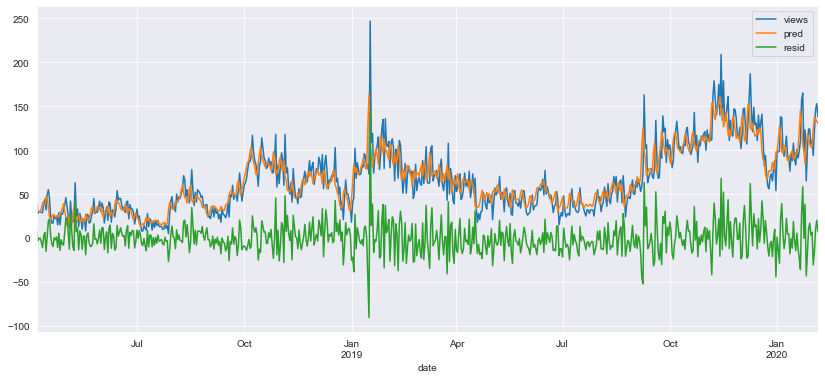

In [9]:
fig, ax = plt.subplots(1, figsize=(14,6))
results_df[['views', 'pred', 'resid']].plot(ax=ax)

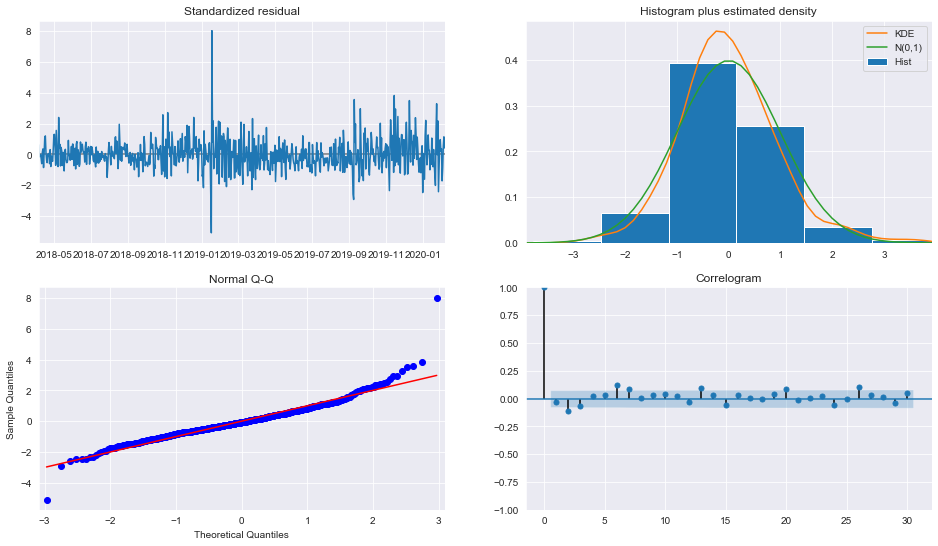

In [10]:
fig = plt.figure(figsize=(16,9))
fig = results.plot_diagnostics(fig=fig, lags=30)

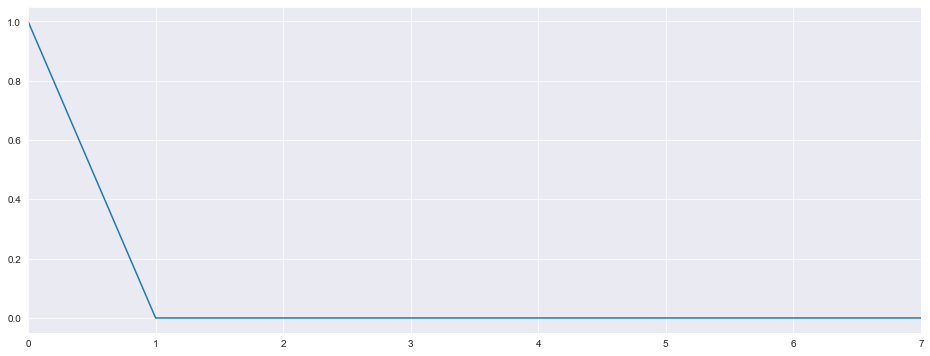

In [11]:
results.impulse_responses(steps=7).plot()

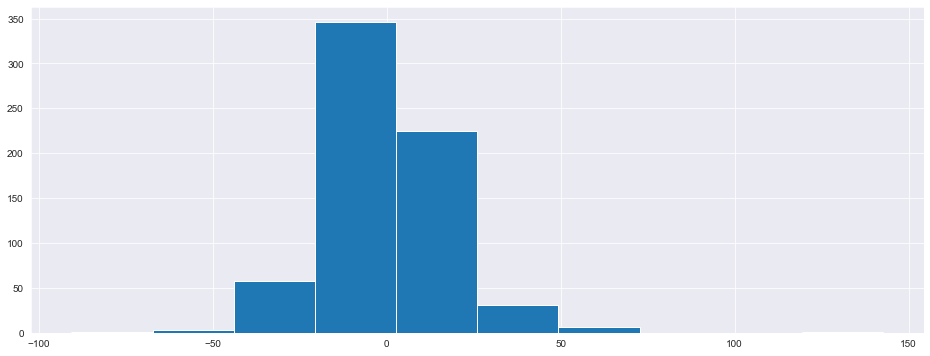

In [12]:
results_df.resid.hist()

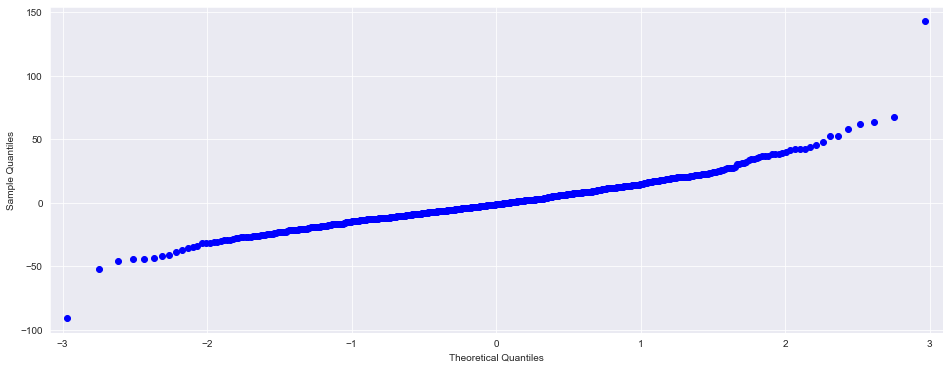

In [13]:
fig = sm.qqplot(results_df.resid)
plt.show()

In [14]:
# https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

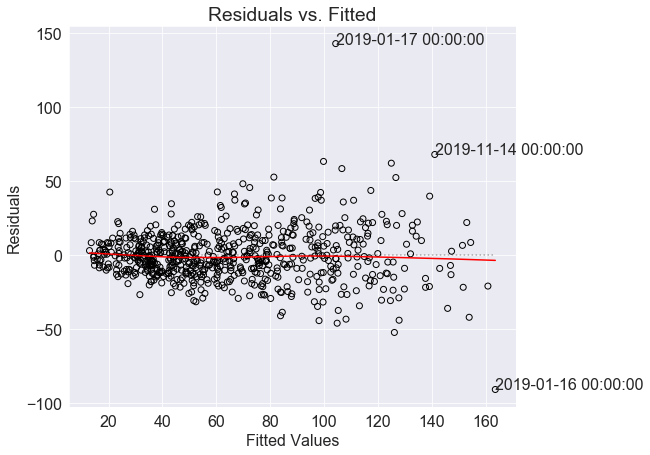

In [15]:
from statsmodels.nonparametric.smoothers_lowess import lowess
residuals = results_df.resid
fitted = results_df.pred
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

In [16]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'get_influence'

In [17]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
    'temp_adv': ['temp_av', 'advertising'],
    'temp': ['temp_av'],
    'temp_score': ['temp_av', 'score_accum'],
    'xmas': ['xmas'],
    'xmas_adv': ['xmas', 'advertising'],
    'xmas_score': ['xmas', 'score_accum'],
    'we': ['we'],
    'we_adv': ['we', 'advertising'],
    'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
    'temp_av',
    'we',
    'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=1,
)
results.summary()

adding AR lags
AR1
build interacting AR lags
temp_av_AR1
we_AR1
xmas_AR1
['advertising', 'score_accum', 'temp_adv', 'temp', 'temp_score', 'xmas', 'xmas_adv', 'xmas_score', 'we', 'we_adv', 'we_score', 'AR1', 'temp_av_AR1', 'we_AR1', 'xmas_AR1']


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  views   No. Observations:                  672
Model:                          ARIMA   Log Likelihood               -2898.660
Date:                Wed, 06 May 2020   AIC                           5831.319
Time:                        22:42:15   BIC                           5907.994
Sample:                    04-06-2018   HQIC                          5861.014
                         - 02-06-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.4646      7.498      1.529      0.126      -3.232      26.161
advertising     2.4902      1.867      1.333      0.182      -1.170       6.150
score_accum     1.9753      1.870      1.056      0.291      -1.691       5.641
temp_adv        0.6851      0.621      1.103      0.270      -0.533       1.903
temp           -1.8043      1.276     -1.414      0.157      -4.304       0.696
temp_score      0.1575      0.613      0.257      0.797      -1.045       1.360
xmas           -3.5730      4.692     -0.762      0.446     -12.768       5.622
xmas_adv       -1.0828      2.938     -0.369      0.712      -6.841       4.675
xmas_score     -1.5978      2.927     -0.546      0.585      -7.334       4.139
we             -2.3923      2.097     -1.141      0.254      -6.503       1.718
we_adv          0.0979      1.259      0.078      0.938      -2.369       2.565
we_score       -0.4173      1.263     -0.330      0.741      -2.894       2.059
AR1             0.5990      0.041     14.569      0.000       0.518       0.680
temp_av_AR1 -1.168e-05      0.005     -0.003      0.998      -0.009       0.009
we_AR1         -0.0401      0.043     -0.942      0.346      -0.124       0.043
xmas_AR1       -0.0474      0.113     -0.418      0.676      -0.270       0.175
sigma2        326.8882      9.936     32.899      0.000     307.414     346.363
===================================================================================
Ljung-Box (Q):                      188.65   Jarque-Bera (JB):              1972.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+18. Standard errors may be unstable.
"""

In [20]:
print(results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      views       & \textbf{  No. Observations:  } &    672      \\
\textbf{Model:}                  &      ARIMA       & \textbf{  Log Likelihood     } & -2898.660   \\
\textbf{Date:}                   & Wed, 06 May 2020 & \textbf{  AIC                } &  5831.319   \\
\textbf{Time:}                   &     22:44:12     & \textbf{  BIC                } &  5907.994   \\
\textbf{Sample:}                 &    04-06-2018    & \textbf{  HQIC               } &  5861.014   \\
\textbf{}                        &   - 02-06-2020   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}         &      11.4646  &        7.498     &     1.529  &         0.126        &       -3.232    &       26.161     \\
\textbf{adverti

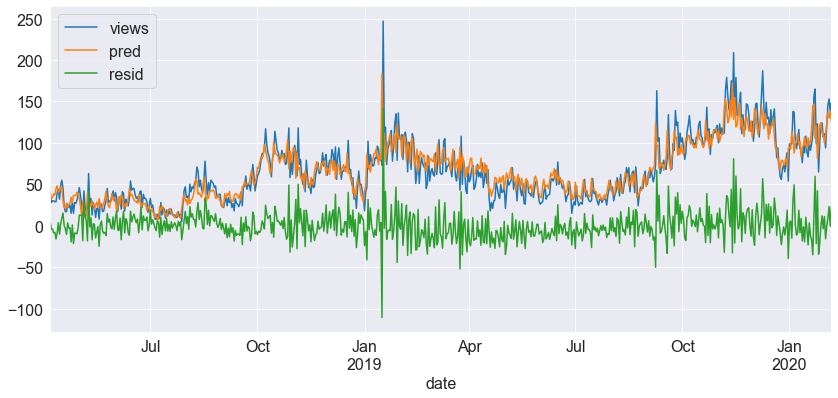

In [19]:
fig, ax = plt.subplots(1, figsize=(14,6))
results_df[['views', 'pred', 'resid']].plot(ax=ax)

In [ ]:
# ^ high confidence that AR component is +ve suggesting other interacting coefficients are 0



In [22]:
interacting_builder = {
    'advertising': ['advertising'],
    'score_accum': ['score_accum'],
    'temp_adv': ['temp_av', 'advertising'],
    'temp': ['temp_av'],
    'temp_score': ['temp_av', 'score_accum'],
#     'xmas': ['xmas'],
#     'xmas_adv': ['xmas', 'advertising'],
#     'xmas_score': ['xmas', 'score_accum'],
#     'we': ['we'],
#     'we_adv': ['we', 'advertising'],
#     'we_score': ['we', 'score_accum'],
}

data_interacting = data.copy()
for col, names in interacting_builder.items():
    data_interacting[col] = data.loc[:, names].sum(axis=1)
    
exog = list(interacting_builder)

interacting_exog_endog = [
    'temp_av',
#     'we',
#     'xmas'
]
 
results, results_df = build_interacting_arma(
    data_interacting,
    endog='views',
    exog=exog,
    interacting_exog_endog=interacting_exog_endog,
    ar_lags=1,
)
results.summary()

adding AR lags
AR1
build interacting AR lags
temp_av_AR1
['advertising', 'score_accum', 'temp_adv', 'temp', 'temp_score', 'AR1', 'temp_av_AR1']


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  views   No. Observations:                  672
Model:                          ARIMA   Log Likelihood               -2908.799
Date:                Wed, 06 May 2020   AIC                           5835.598
Time:                        23:18:39   BIC                           5876.190
Sample:                    04-06-2018   HQIC                          5851.319
                         - 02-06-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.7394      7.130      1.085      0.278      -6.236      21.715
advertising     1.6324      0.258      6.327      0.000       1.127       2.138
score_accum     0.5644      0.090      6.291      0.000       0.389       0.740
temp_adv        0.6318      0.228      2.768      0.006       0.184       1.079
temp           -0.9998      0.180     -5.569      0.000      -1.352      -0.648
temp_score     -0.4499      0.090     -4.981      0.000      -0.627      -0.273
AR1             0.6048      0.040     15.056      0.000       0.526       0.684
temp_av_AR1    -0.0008      0.004     -0.173      0.863      -0.009       0.008
sigma2        336.7203      9.672     34.813      0.000     317.763     355.678
===================================================================================
Ljung-Box (Q):                      146.46   Jarque-Bera (JB):              1953.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.91e+19. Standard errors may be unstable.
"""

In [54]:
data_interacting.head()

,quantity,advertising,score_accum,temp_av,xmas,we,temp_adv,temp_score,xmas_adv,xmas_score,we_adv,we_score,AR1,AR2,temp_av_AR1,temp_av_AR2,xmas_AR1,xmas_AR2,we_AR1,we_AR2
date,,,,,,,,,,,,,,,,,,,,
2018-02-12,2.0,0.040417,0.0,2.944444,0,0,2.984861,2.944444,0.040417,0.0,0.040417,0.0,2.0,0.0,5.888889,0.000000,0.0,0.0,0.0,0.0
2018-02-13,2.0,0.040417,4.0,4.166667,0,0,4.207083,8.166667,0.040417,4.0,0.040417,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2018-02-14,0.0,0.040417,6.0,3.333333,0,0,3.373750,9.333333,0.040417,6.0,0.040417,6.0,0.0,1.0,0.000000,3.333333,0.0,0.0,0.0,0.0
2018-02-15,0.0,0.040417,8.0,7.277778,0,0,7.318194,15.277778,0.040417,8.0,0.040417,8.0,1.0,2.0,7.277778,14.555556,0.0,0.0,0.0,0.0
2018-02-16,1.0,0.040417,10.0,4.666667,0,0,4.707083,14.666667,0.040417,10.0,0.040417,10.0,2.0,0.0,9.333333,0.000000,0.0,0.0,0.0,0.0


In [55]:
data_interacting.tail()

,quantity,advertising,score_accum,temp_av,xmas,we,temp_adv,temp_score,xmas_adv,xmas_score,we_adv,we_score,AR1,AR2,temp_av_AR1,temp_av_AR2,xmas_AR1,xmas_AR2,we_AR1,we_AR2
date,,,,,,,,,,,,,,,,,,,,
2020-02-03,3.0,5.248167,263.0,9.055556,0,0,14.303722,272.055556,5.248167,263.0,5.248167,263.0,12.0,9.0,108.666667,81.500000,0.0,0.0,0.0,0.0
2020-02-04,12.0,5.248167,263.0,6.944444,0,0,12.192611,269.944444,5.248167,263.0,5.248167,263.0,9.0,4.0,62.500000,27.777778,0.0,0.0,0.0,0.0
2020-02-05,9.0,5.248167,263.0,4.833333,0,0,10.081500,267.833333,5.248167,263.0,5.248167,263.0,4.0,10.0,19.333333,48.333333,0.0,0.0,0.0,0.0
2020-02-06,4.0,5.248167,263.0,3.611111,0,0,8.859278,266.611111,5.248167,263.0,5.248167,263.0,10.0,NaN,36.111111,NaN,0.0,NaN,0.0,NaN
2020-02-07,10.0,5.248167,263.0,5.611111,0,0,10.859278,268.611111,5.248167,263.0,5.248167,263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df = pd.DataFrame({1:[1,2,3], 2:[1,2,3], 3:[1,2,3]}).set_index(1)

In [60]:
df[:2]

,2,3
1,,
1,1,1
2,2,2
